# Polish Twitter Partisan Networks

In [28]:
path = "/home/piotr/projects/twitter/"
path_data = '/media/piotr/INTENSO/polish_twitter_data/'
import sys
import os
sys.path.append(os.path.join(path, 'src'))
import re
import pandas as pd
import networkx as nx
import numpy as np
import datetime
from datetime import datetime
import gc
import json
from tqdm.notebook import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import pickle
import twitter_models
from twitter_models.network import build_twitter_network_multi, build_twitter_network, multi_to_di
from twitter_tools.utils import check_errors, read_files
cols_from = ["in_reply_to_user_id_str"]
cols_to = ["retweeted_status-user-id_str", "quoted_status-user-id_str"]
import logging
logger = logging.getLogger(__name__)
from functools import partial
from itertools import product
from operator import itemgetter

## Building networks partisan networks:
First, I build time-dynamic directional networks for both parties - government and opposition followers. The networks are represented as dictionaries of daily `networkx` objects, describing connections between the users in the sample. The edges are defined as followed:
- reply to a tweet (column `in_reply_to_user_id_str`) is treated as an directional edge from as an outgoing node from the user that replies
- retweet and quotation (columns `["retweeted_status-user-id_str", "quoted_status-user-id_str"]` in the Twitter API output) are treated as nodes going into the user

Each edge is associated with the tweet id string associated with that edge.

**Data filtering**
As per usual, I load the IDs that were judged to be removed in the preprocessing phase. I define a filter function to remove them from the data frames.

In [2]:
DROP_IDS = json.load(open(os.path.join(path, 'results/cleaning/DROP_IDS.json'), 'r'))
def filter_fun(df, drop_ids: list):
    df = df.loc[np.logical_not(df.id_str.isin(drop_ids)),:]
    return df
ff = partial(filter_fun, drop_ids = DROP_IDS)

#### Build directional dynamic multi-graph for opposition data:

In [4]:
opp_path = os.path.join(path, 'results/network/opp_network_multi.p')
if os.path.isfile(opp_path):
    opp_network = pickle.load(open(opp_path,'rb'))
else:
    path_tmp = os.path.join(path_data, 'opp')
    reg = '\d{4}\_\d{2}\_\d{2}'
    until = datetime(year = 2020, month = 5, day = 15)
    files  = [f for f in os.listdir(path_tmp) if 'csv' in f and datetime.strptime(re.search(reg, f).group(0), '%Y_%m_%d') <= until]
    opp_network = dict()
    for file in tqdm(sorted(files)):
        dat = pd.read_csv(os.path.join(path_tmp, file), index_col = 0, dtype = str)
        G = build_twitter_network_multi(dat, col_node = 'user-id_str', col_label = 'id_str', 
                                    cols_from = cols_from, cols_to = cols_to, filter_fun = ff)
        day = pd.to_datetime(dat.created_at).dt.strftime('%Y_%m_%d').unique()[0]
        opp_network[day] = G
        gc.collect()
    pickle.dump(opp_network, open(opp_path, 'wb'))

#### Build directional dynamic graph for opposition data:

In [13]:
opp_path = os.path.join(path, 'results/network/opp_network.p')
if os.path.isfile(opp_path):
    opp_network = pickle.load(open(opp_path, 'rb'))
else:
    opp_network = {k:multi_to_di(v) for k, v in opp_network.items()}
    pickle.dump(opp_network, open(opp_path, 'wb'))

#### Build directional dynamic multi-graph for government data:

In [5]:
gov_path = os.path.join(path, 'results/network/gov_network_multi.p')
if os.path.isfile(gov_path):
    gov_network = pickle.load(open(gov_path,'rb'))
else:
    path_tmp = os.path.join(path_data, 'gov')
    reg = '\d{4}\_\d{2}\_\d{2}'
    until = datetime(year = 2020, month = 5, day = 15)
    files  = [f for f in os.listdir(path_tmp) if 'csv' in f and datetime.strptime(re.search(reg, f).group(0), '%Y_%m_%d') <= until]
    gov_network = dict()
    for file in tqdm(sorted(files)):
        dat = pd.read_csv(os.path.join(path_tmp, file), index_col = 0, dtype = str)
        G = build_twitter_network_multi(dat, col_node = 'user-id_str', col_label = 'id_str', 
                                    cols_from = cols_from, cols_to = cols_to, filter_fun = ff)
        day = pd.to_datetime(dat.created_at).dt.strftime('%Y_%m_%d').unique()[0]
        gov_network[day] = G
        gc.collect()
    pickle.dump(gov_network, open(gov_path, 'wb'))

#### Build directional dynamic graph for government data:

In [15]:
gov_path = os.path.join(path, 'results/network/gov_network.p')
if os.path.isfile(gov_path):
    gov_network = pickle.load(open(gov_path, 'rb'))
else:
    gov_network = {k:multi_to_di(v) for k, v in gov_network.items()}
    pickle.dump(gov_network, open(gov_path, 'wb'))

## Join the networks
- secondly, build a network joining the daily networks to analyze the interactions between the users from both networks
- only keep the IDs of the users that were present in the sample

In [3]:
def join_networks(G1, G2, nodes_subset):
    g1 = G1.subgraph(nodes_subset) #keep just the joint nodes
    g2 = G2.subgraph(nodes_subset) #
    connected = nx.compose(g1, g2)
    connected.add_nodes_from(nodes_subset)
    return connected

In [7]:
gov_ids = pickle.load(open(os.path.join(path, 'data/sample/gov_sample.pickle'),'rb'))
opp_ids = pickle.load(open(os.path.join(path, 'data/sample/opp_sample.pickle'),'rb'))
gov_source = {k:'gov' for k in gov_ids}
opp_source = {k:'opp' for k in opp_ids}
source = {**gov_source, **opp_source}
ids = list(source.keys())
path_tmp = os.path.join(path, 'results/network/twitter_network.p')
if not os.path.isfile(path_tmp):
    twitter_network = {k:join_networks(v, opp_network[k], nodes_subset = ids) for k, v in tqdm(gov_network.items())}
    for day, graph in twitter_network.items():
        nx.set_node_attributes(graph, source, 'source')
    pickle.dump(twitter_network, open(path_tmp, 'wb'))
else:
    twitter_network = pickle.load(open(path_tmp, 'rb'))

In [4]:
def filter_edges(G, filter_fun):
    edges = []
    for n1, n2, w in G.edges:
        if filter_fun(G, n1, n2):
            edges.append((n1, n2, w))
    G1 = G.edge_subgraph(edges)
    return G1

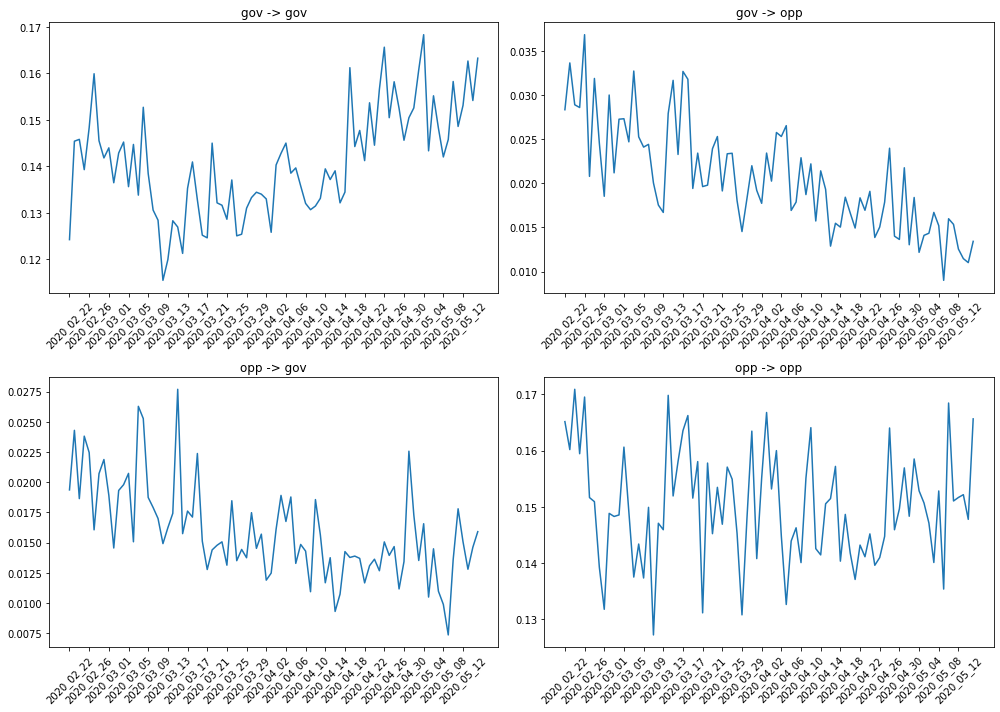

In [79]:
%matplotlib inline
fig, ax = plt.subplots(2, 2, figsize = (14, 10))
ax = ax.ravel()
for i, (s1, s2) in enumerate(product(['gov','opp'], repeat=2)):
    ff = lambda G, n1, n2: G.nodes[n1]['source'] == s1 and G.nodes[n2]['source'] == s2
    G = {k:filter_edges(v, ff) for k, v in twitter_network.items()}
    if s1 == 'gov':
        props = {k:len(G[k].edges)/len(gov_network[k].edges) for k in G.keys()}
    else:
        props = {k:len(G[k].edges)/len(opp_network[k].edges) for k in G.keys()}
    ax[i].plot(range(len(props.keys())), list(props.values()))
    ax[i].set_title(f'{s1} -> {s2}')
    xt = list(range(0,len(props.keys()), 5))
    ax[i].set_xticks(xt)
    ax[i].set_xticklabels(itemgetter(*xt)(list(props.keys())), rotation = 45)
plt.tight_layout()
plt.show()

### Store the edges as pandas data frame to use for analysis

In [ ]:
dat = pd.DataFrame()
for k in twitter_network:
    

### Subset only COVID related tweets
- Next, I analyzed the patterns of network homiphily only considering the tweets related to COVID-19

In [6]:
def subset_edges(G, names):
    edges = [(n1,n2,w) for n1,n2,w in tqdm(G.edges) if w in names]
    return G.edge_subgraph(edges)

In [7]:
path_covid_ids = os.path.join(path, 'results/covid_ids.json')
if os.path.isfile(path_covid_ids):
    ids = json.load(open(path_covid_ids, 'r'))
else:
    ids = []
    vocab  = "korona|koronawirus|wirus|epidemia|pandemia|choroba|covid|covid19|maseczka|sars|zarażenie|zarażony|zarażać|chorować|ofiary|ofiara|corona|lockdown|szpital|chory"
    for dat in tqdm(read_files(os.path.join(path, 'data/clean'), ndays = 84, dtype = str)):
        ids.extend(dat.loc[dat.lemmatized.astype(str).str.contains(vocab), ('id_str')].tolist())
    json.dump(ids, open(path_covid_ids, 'w'))

In [12]:
path_covid = os.path.join(path, 'results/network/covid_network_all.p')
path_opp = os.path.join(path, 'results/network/covid_network_opp.p')
path_gov = os.path.join(path, 'results/network/covid_network_opp.p')
if os.path.isfile(path_tmp):
    covid_network = pickle.load(open(path_covid, 'rb'))
    covid_network_gov = pickle.load(open(path_gov, 'rb'))
    covid_network_opp = pickle.load(open(path_opp, 'rb'))
else:
    path_tmp = os.path.join(path_data, 'opp')
    reg = '\d{4}\_\d{2}\_\d{2}'
    until = datetime(year = 2020, month = 5, day = 15)
    files  = [f for f in os.listdir(path_tmp) if 'csv' in f and datetime.strptime(re.search(reg, f).group(0), '%Y_%m_%d') <= until]
    opp_network = dict()
    for file in tqdm(sorted(files)):
        dat = pd.read_csv(os.path.join(path_tmp, file), index_col = 0, dtype = str)
        dat = dat.loc[dat['id_str'].isin(ids),:]
        G = build_twitter_network_multi(dat, col_node = 'user-id_str', col_label = 'id_str', 
                                    cols_from = cols_from, cols_to = cols_to, filter_fun = ff)
        day = pd.to_datetime(dat.created_at).dt.strftime('%Y_%m_%d').unique()[0]
        opp_network[day] = G
        gc.collect()

    path_tmp = os.path.join(path_data, 'gov')
    reg = '\d{4}\_\d{2}\_\d{2}'
    until = datetime(year = 2020, month = 5, day = 15)
    files  = [f for f in os.listdir(path_tmp) if 'csv' in f and datetime.strptime(re.search(reg, f).group(0), '%Y_%m_%d') <= until]
    gov_network = dict()
    for file in tqdm(sorted(files)):
        dat = pd.read_csv(os.path.join(path_tmp, file), index_col = 0, dtype = str)
        dat = dat.loc[dat['id_str'].isin(ids),:]
        G = build_twitter_network_multi(dat, col_node = 'user-id_str', col_label = 'id_str', 
                                    cols_from = cols_from, cols_to = cols_to, filter_fun = ff)
        day = pd.to_datetime(dat.created_at).dt.strftime('%Y_%m_%d').unique()[0]
        gov_network[day] = G
        gc.collect()

    del(dat)
    gc.collect()

    gov_ids = pickle.load(open(os.path.join(path, 'data/sample/gov_sample.pickle'),'rb'))
    opp_ids = pickle.load(open(os.path.join(path, 'data/sample/opp_sample.pickle'),'rb'))
    gov_source = {k:'gov' for k in gov_ids}
    opp_source = {k:'opp' for k in opp_ids}
    source = {**gov_source, **opp_source}
    ids = list(source.keys())
    covid_network = {k:join_networks(v, opp_network[k], nodes_subset = ids) for k, v in tqdm(gov_network.items())}
    for day, graph in covid_network.items():
        nx.set_node_attributes(graph, source, 'source')
    #save
    pickle.dump(covid_network, open(path_covid, 'wb'))
    pickle.dump(covid_network, open(path_opp, 'wb'))
    pickle.dump(covid_network, open(path_gov, 'wb'))

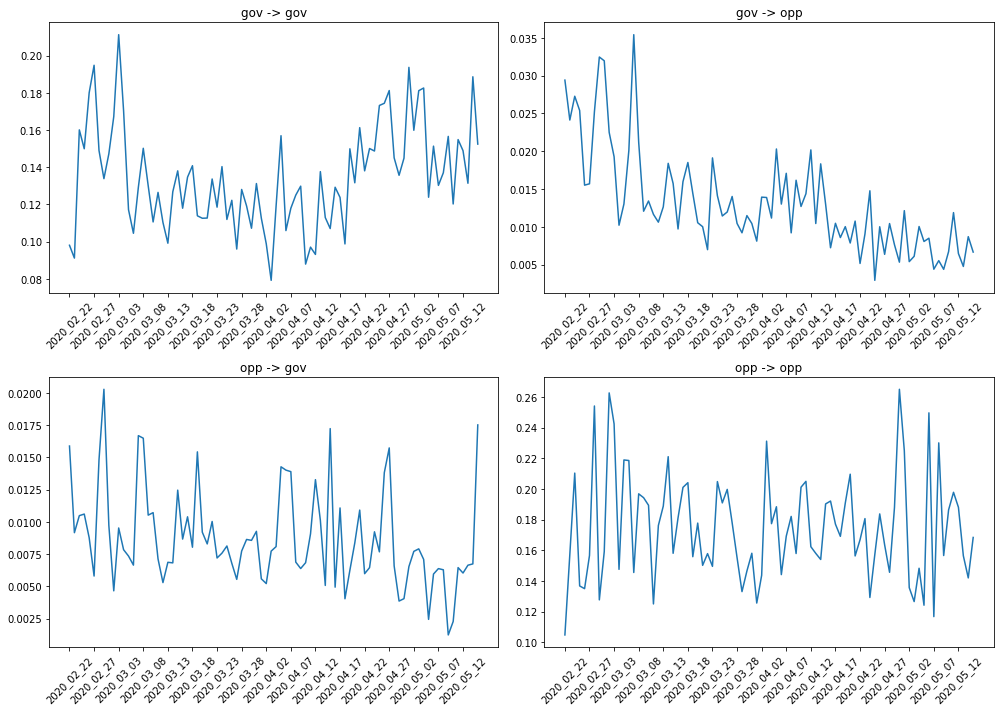

In [36]:
%matplotlib inline
fig, ax = plt.subplots(2, 2, figsize = (14, 10))
ax = ax.ravel()
for i, (s1, s2) in enumerate(product(['gov','opp'], repeat=2)):
    ff = lambda G, n1, n2: G.nodes[n1]['source'] == s1 and G.nodes[n2]['source'] == s2
    G = {k:filter_edges(v, ff) for k, v in covid_network.items()}
    if s1 == 'gov':
        props = {k:len(G[k].edges)/len(covid_network_gov[k].edges) for k in G.keys()}
    else:
        props = {k:len(G[k].edges)/len(covid_network_opp[k].edges) for k in G.keys()}
    ax[i].plot(range(len(props.keys())), list(props.values()))
    ax[i].set_title(f'{s1} -> {s2}')
    xt = list(range(0,len(props.keys()), 5))
    ax[i].set_xticks(xt)
    ax[i].set_xticklabels(itemgetter(*xt)(list(props.keys())), rotation = 45)
plt.tight_layout()
plt.show()